In [2]:
from ou_noise import ou
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

[2.13134966 0.49912879 0.0502928 ]


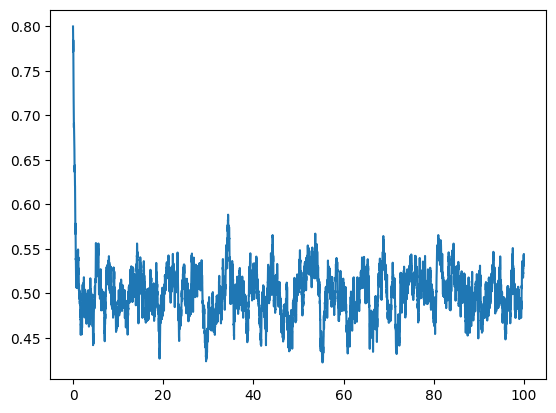

In [3]:
t = numpy.arange(0, 100, 0.01)
# simulate a path of the OU process on a given grid t, starting with x_0 = 0.8
x = ou.path(0.8, t, 2.0, 0.5, 0.05)                                           
plt.plot(t,x)

params = ou.mle(t, x)
print(params)

# Output: [2.09360033 0.49863601 0.04992896]

### test

/Users/mistletoe/miniconda3/envs/examples/lib/python3.11/site-packages/rqdatac/client.py:206: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
/Users/mistletoe/miniconda3/envs/examples/lib/python3.11/site-packages/rqdatac/client.py:245: UserWarning: Your account will be expired after  21 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


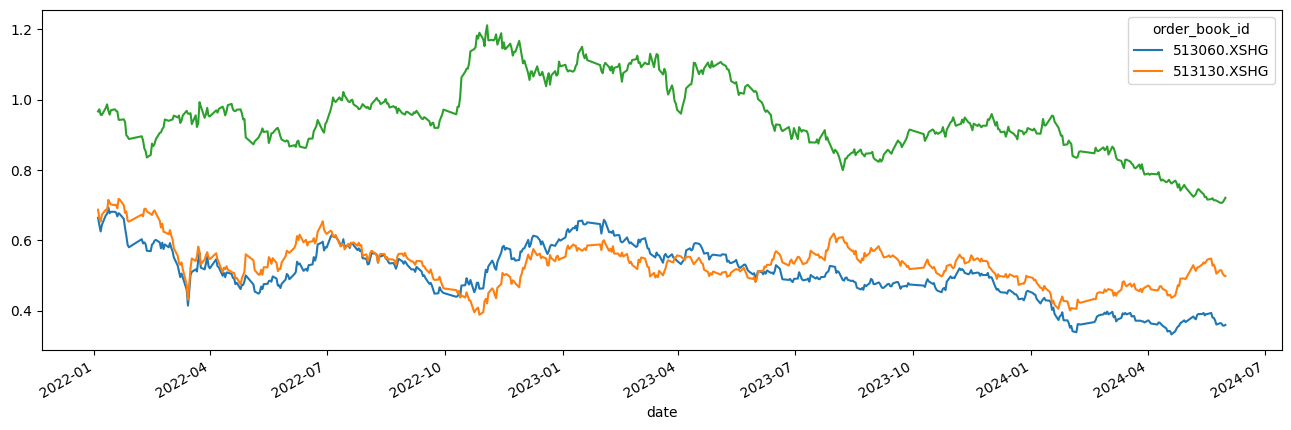

In [26]:
import rqdatac
rqdatac.init()
def plot(code1, code2):
    code1 = rqdatac.id_convert(code1)
    code2 = rqdatac.id_convert(code2)
    df_price = rqdatac.get_price(
                                order_book_ids=[code1, code2],
                                start_date='2022-01-01',
                                end_date='2024-05-31',
                                frequency='1d'
                                )[['close']].unstack(level=0)
    df_price.columns = df_price.columns.droplevel(0)
    df_price.plot(figsize = (16,5))
    df_price['div'] = df_price['513060.XSHG'] / df_price['513130.XSHG']
    df_price['div'].plot(figsize = (16,5))

    return df_price
df_price = plot('513060', '513130')


In [28]:
from statsmodels.tsa.stattools import coint 
_, pvalue, _ = coint(df_price['513060.XSHG'], df_price['513130.XSHG']) 
pvalue

0.9168895293247727

<Axes: xlabel='date'>

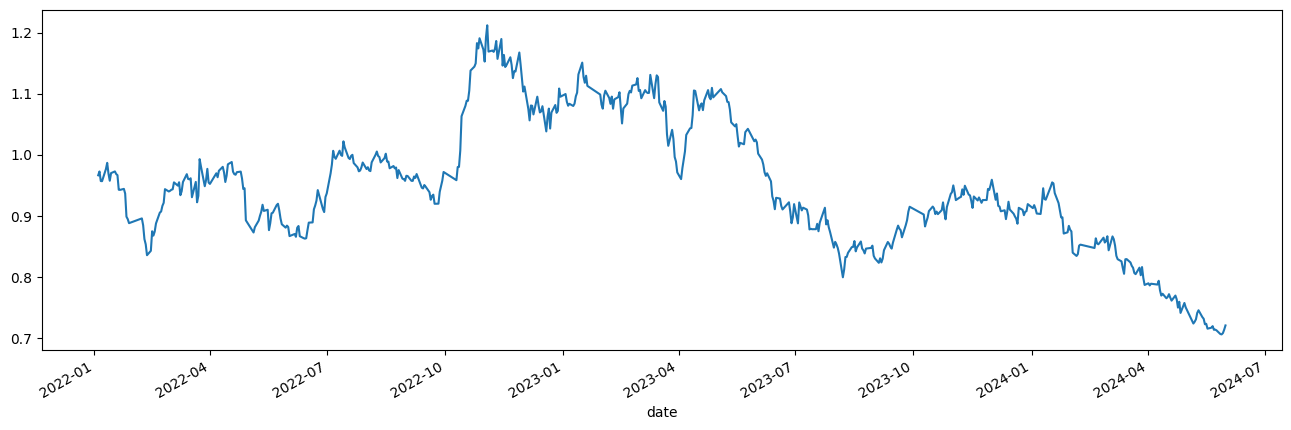

In [22]:
df_price['div'] = df_price['513060.XSHG'] / df_price['513130.XSHG']
df_price['div'].plot(figsize = (16,5))

### 期货配对

In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr, spearmanr

data = pd.read_excel(r'futures.xlsx')

#测试相关性和协整关系
_, pv_coint, _ = coint(data['CU.SHF'], data['SF.CZC'])
corr, pv_corr = pearsonr(data['CU.SHF'], data['SF.CZC'])
print("Cointegration pvalue : %0.4f"%pv_coint)
print("Correlation coefficient is %0.4f and pvalue is %0.4f"%(corr, pv_corr))

Cointegration pvalue : 0.0000
Correlation coefficient is 0.8770 and pvalue is 0.0000


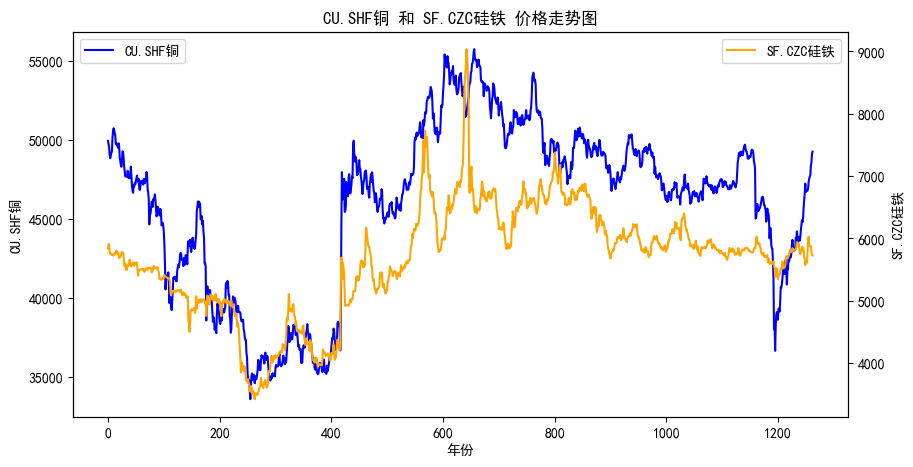

In [30]:
def plotSettlePrice(df, var1, var2, var1_name, var2_name, title):
    temp = df[[var1, var2]].dropna()
    fig = plt.figure(figsize=(10,5))
    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    ax1 = fig.add_subplot(111)
    ax1.plot(temp[var1], c = 'blue')
    ax1.set_ylabel(var1_name)
    ax1.set_title(title)
    plt.legend(loc = 'upper left', labels=[var1_name])
    ax1.set_xlabel('年份')    
    
    ax2 = ax1.twinx()  # this is the important function
    ax2.plot(temp[var2], c = 'orange')
    ax2.set_ylabel(var2_name)
    ax2.set_xlabel('年份')        
    plt.legend(loc = 'upper right', labels=[var2_name])
    plt.show()    

plotSettlePrice(data, 'CU.SHF', 'SF.CZC', 'CU.SHF铜', 'SF.CZC硅铁',
                'CU.SHF铜 和 SF.CZC硅铁 价格走势图')

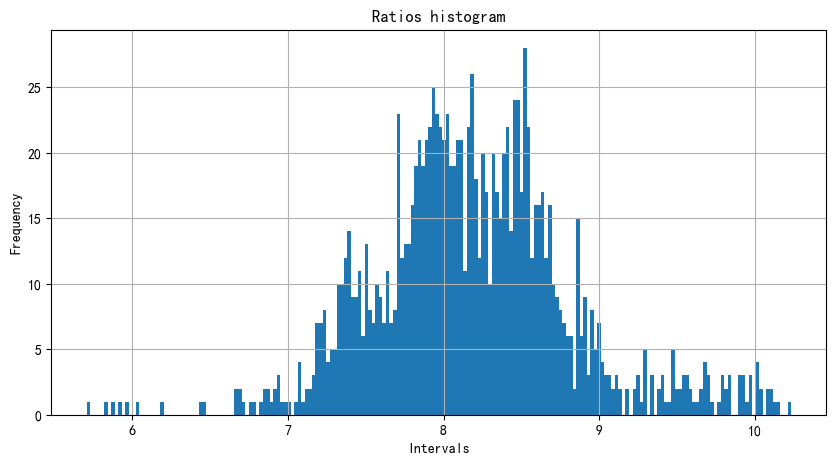

In [31]:
def getRatios(df, var1, var2, plotOrNot):
    df1 = df[[var1, var2]].dropna()
    S1 = df1[var1]
    S2 = df1[var2]
    ratios = S1 / S2  
    if plotOrNot:
        plt.figure(figsize=(10,5))            
        ratios.hist(bins = 200)
        plt.title("Ratios histogram")
        plt.ylabel('Frequency')
        plt.xlabel('Intervals')
        plt.show()
    return S1, S2, ratios

S1, S2, ratios = getRatios(data, 'CU.SHF', 'SF.CZC', 1)

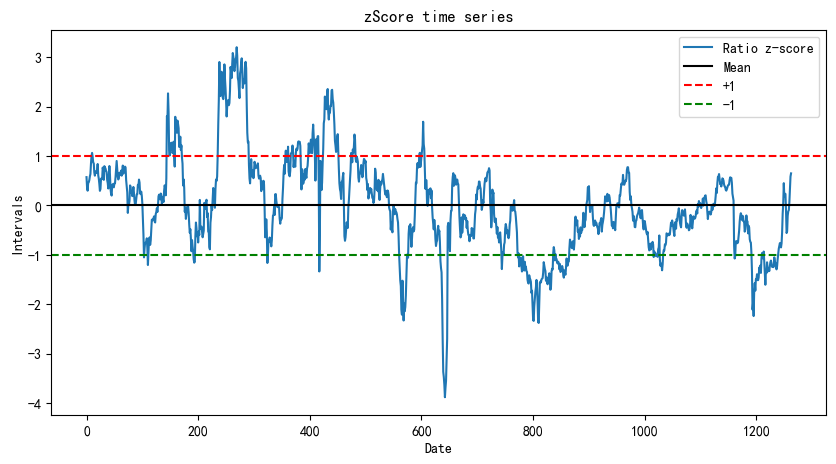

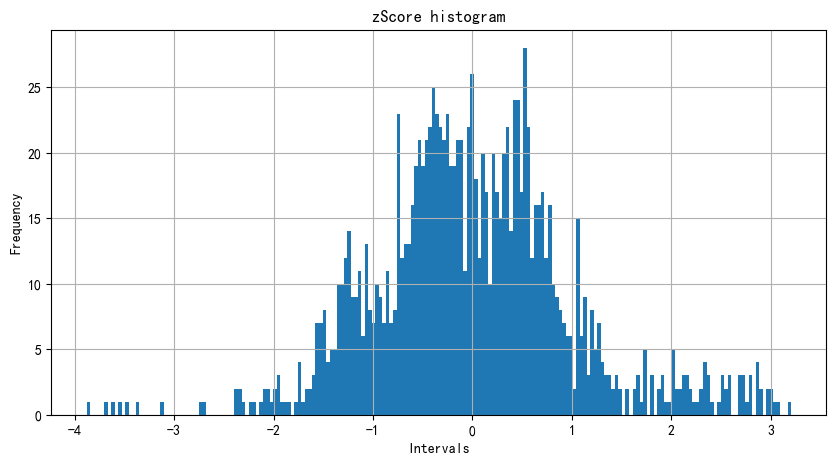

In [32]:
def getZScore(ratios, plotOrNot):
    
    zScore = (ratios - ratios.mean()) / ratios.std()    
    
    if plotOrNot:
        zScore.plot(figsize=(10,5))
        plt.axhline(zScore.mean(), color='black')
        plt.axhline(1.0, color='red', linestyle='--')
        plt.axhline(-1.0, color='green', linestyle='--')
        plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
        plt.title("zScore time series")
        plt.xlabel('Date')
        plt.ylabel('Intervals')

        plt.show()
    
        plt.figure(figsize=(10,5))
        zScore.hist(bins = 200)
        plt.title("zScore histogram")
        plt.ylabel('Frequency')
        plt.xlabel('Intervals')        
        plt.show()
    return zScore

zScore = getZScore(ratios, 1)

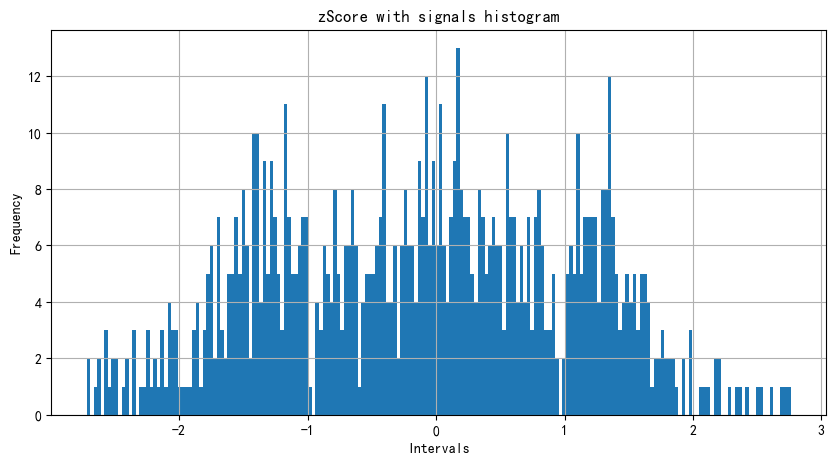

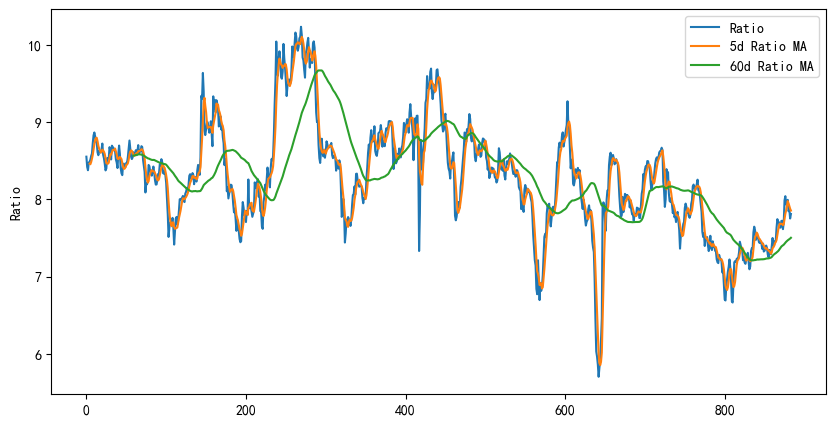

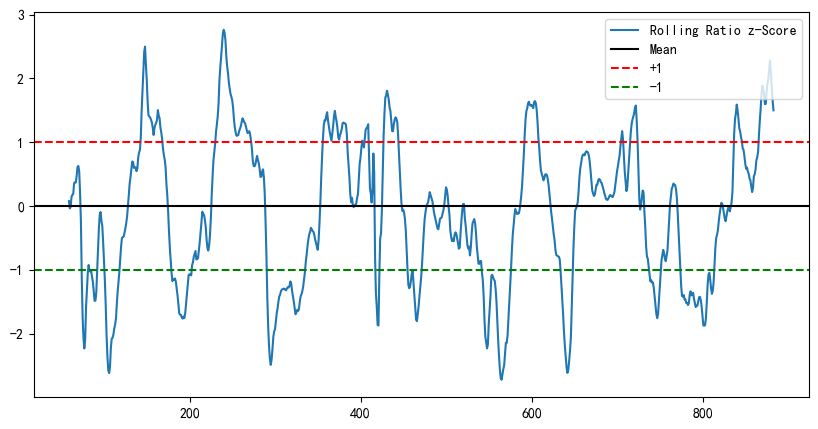

In [33]:
def getMovingIndex(ratios, train_pct, w1, w2, plotOrNot):
    ### w1 < w2，拆分训练集+验证集，训练集的比例是train_pct    
    length = len(ratios)
    trainLength = int(train_pct * length)
    train = ratios[:trainLength]
    test = ratios[trainLength:]
    
    # 计算指标moving_average, moving_std，以及moving_z_score：这里可以使用gplearn！！
    # 希望通过moving_z_score找到信号
    ratios_mavg1 = train.rolling(window=w1, center=False).mean()
    ratios_mavg2 = train.rolling(window=w2, center=False).mean()
    std = train.rolling(window=w2, center=False).std()
    zscore_mv = (ratios_mavg1 - ratios_mavg2) / std
    
    if plotOrNot:
        plt.figure(figsize=(10,5))
        zscore_mv.hist(bins = 200)
        plt.title("zScore with signals histogram")
        plt.ylabel('Frequency')
        plt.xlabel('Intervals')        
        plt.show()        
        
        plt.figure(figsize=(10,5))
        plt.plot(train.index, train.values)
        plt.plot(ratios_mavg1.index, ratios_mavg1.values)
        plt.plot(ratios_mavg2.index, ratios_mavg2.values)
        plt.legend(['Ratio','%dd Ratio MA'%w1, '%dd Ratio MA'%w2])
        plt.ylabel('Ratio')
        plt.show()    
    
        plt.figure(figsize=(10,5))
        zscore_mv.plot()
        plt.axhline(0, color='black')
        plt.axhline(1.0, color='red', linestyle='--')
        plt.axhline(-1.0, color='green', linestyle='--')
        plt.legend(loc='upper right', labels = ['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
        plt.show()
    return train, test, zscore_mv

train, test, zscore_mv = getMovingIndex(ratios, 0.7, 5, 60, 1)

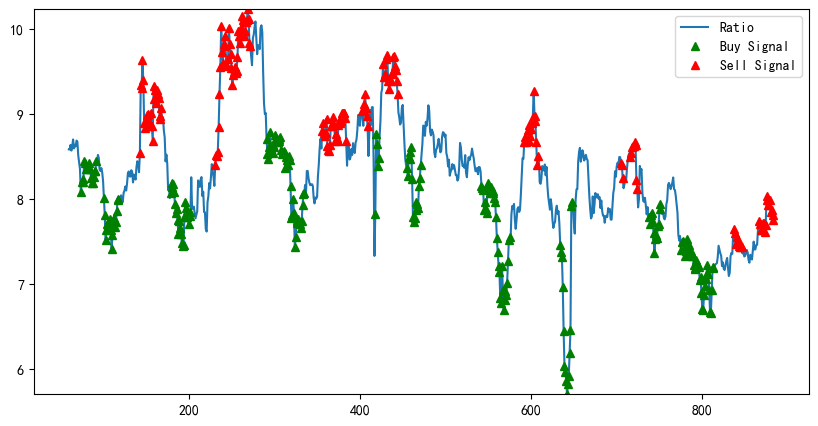

In [44]:
def getTradeSignal(train, zscore_mv, w2, plotOrNot):
    # Plot the ratios and buy and sell signals from z score
    plt.figure(figsize=(10,5))

    train[w2:].plot()
    buy = train.copy()
    sell = train.copy()
    
    # 信号ratios = CU.SHF / SF.CZC，衍生出buy和sell。
    # 其他时候ratios = 0.
    buy[zscore_mv > -1] = 0
    sell[zscore_mv < 1] = 0
    
    if plotOrNot:
        buy[60:].plot(color='g', linestyle='None', marker='^')
        sell[60:].plot(color='r', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1,x2,ratios.min(),ratios.max()))
        plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
        plt.show()    

    return buy, sell

buy, sell = getTradeSignal(train, zscore_mv, 60, 1)


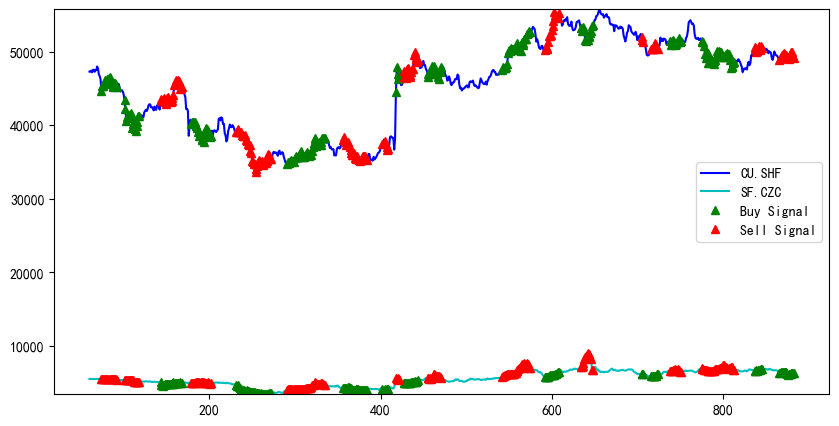

In [45]:
def Trade2Contract(df, var1, var2, buy, sell, w2):
    S1, S2, ratios = getRatios(df, var1, var2, 0)
    plt.figure(figsize=(10,5))
    S1 = S1.reindex(index = buy.index)
    S2 = S2.reindex(index = buy.index)
    S1[w2:].plot(color='b')
    S2[w2:].plot(color='c')

    # buyR和sellR先填充0。
    buyR = 0 * S1.copy()
    sellR = 0 * S1.copy()
    
    # 即buy只有在信号ratios<-1的时候保持ratios原值，此刻long S1=CU.SHF，short S2=SF.CZC
    buyR[buy!=0] = S1[buy!=0]
    sellR[buy!=0] = S2[buy!=0]

    # 即sell只有在信号ratios>1的时候保持ratios原值，此刻short S1=CU.SHF，long S2=SF.CZC。
    buyR[sell != 0] = S2[sell != 0]
    sellR[sell != 0] = S1[sell != 0]

    buyR[w2:].plot(color='g', linestyle='None', marker='^')
    sellR[w2:].plot(color='r', linestyle='None', marker='^')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, min(S1.min(), S2.min()),max(S1.max(), S2.max())))

    plt.legend([var1, var2, 'Buy Signal', 'Sell Signal'])
    plt.show()    

Trade2Contract(data, 'CU.SHF', 'SF.CZC', buy, sell, 60)

In [41]:
data['SF.CZC'].pct_change()[1:]

1       0.011648
2       0.000677
3      -0.021320
4      -0.005187
5       0.000348
          ...   
1258    0.000681
1259   -0.000340
1260   -0.015317
1261   -0.008642
1262   -0.001743
Name: SF.CZC, Length: 1262, dtype: float64